In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "./cropped_input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

test
train



In [10]:
from subprocess import check_output
print(check_output(["ls", "./cropped_input/train"]).decode("utf8"))

Type_1
Type_2
Type_3



In [11]:
import glob
train= glob.glob("./cropped_input/train/**/*.jpg")#+glob.glob("../input/additional/**/*.jpg")
train = pd.DataFrame([[p.split('/')[3],p.split('/')[4],p] for p in train], columns = ['type','image','path'])
test = glob.glob("./cropped_input/test/*.jpg")
test = pd.DataFrame([[p.split('/')[3],p] for p in test], columns = ['image','path'])

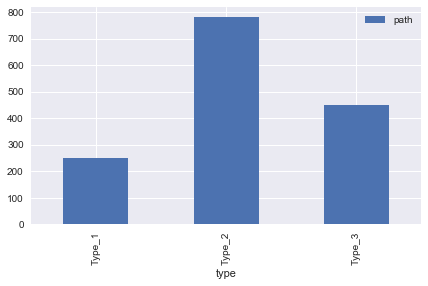

In [12]:
from PIL import ImageFilter, ImageStat, Image, ImageDraw
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import cv2

types = train.groupby('type', as_index=False).count()
types.plot(kind='bar', x='type', y='path', figsize=(7,4))

In [13]:
types

,type,image,path
0,Type_1,249,249
1,Type_2,780,780
2,Type_3,449,449


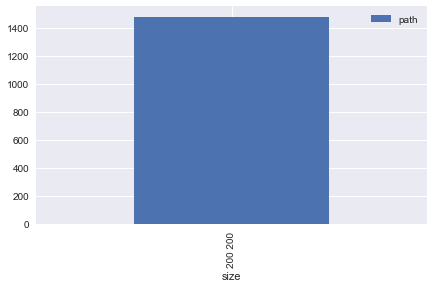

In [14]:
from multiprocessing import Pool, cpu_count

def im_multi(path):
    try:
        im_stats_im_ = Image.open(path)
        return [path, {'size': im_stats_im_.size}]
    except:
        print(path)
        return [path, {'size': [0,0]}]

def im_stats(im_stats_df):
    im_stats_d = {}
    p = Pool(cpu_count())
    ret = p.map(im_multi, im_stats_df['path'])
    for i in range(len(ret)):
        im_stats_d[ret[i][0]] = ret[i][1]
    im_stats_df['size'] = im_stats_df['path'].map(lambda x: ' '.join(str(s) for s in im_stats_d[x]['size']))
    return im_stats_df

train = im_stats(train)
sizes = train.groupby('size', as_index=False)['path'].count()
_ = sizes.plot(kind='bar', x='size', y='path', figsize=(7,4))

In [15]:
sizes

,size,path
0,200 200,1478


In [17]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras import optimizers

def get_im_cv2(path):
    img = cv2.imread(path)
    resized = cv2.resize(img, (200, 200), cv2.INTER_LINEAR)
    return [path, resized]

def normalize_image_features(paths):
    imf_d = {}
    p = Pool(cpu_count())
    ret = p.map(get_im_cv2, paths)
    for i in range(len(ret)):
        imf_d[ret[i][0]] = ret[i][1]
    ret = []
    fdata = [imf_d[f] for f in paths]
    fdata = np.array(fdata, dtype=np.uint8)
    fdata = fdata.transpose((0, 3, 1, 2))
    fdata = fdata.astype('float32')
    fdata = fdata / 255
    return fdata

#train = glob.glob('../input/train/**/*.jpg') + glob.glob('../input/additional/**/*.jpg')
print(len(train))
#train = pd.DataFrame([[p.split('/')[3],p.split('/')[4],p] for p in train], columns = ['type','image','path'])
train = train[train['size'] != '0 0'].reset_index(drop=True) #remove bad images
train_data = normalize_image_features(train['path'])
#np.save('train.npy', train_data, allow_pickle=True, fix_imports=True)
#train_data = np.load('train.npy')

le = LabelEncoder()
train_target = le.fit_transform(train['type'].values)
#np.save('train_target.npy', train_target, allow_pickle=True, fix_imports=True)
#train_target = np.load('train_target.npy')

def create_model(opt_):
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(3, 200, 200)))
    model.add(Convolution2D(8, 3, 3))
    model.add(Dropout(0.2))
    model.add(Dense(12))
    model.add(Dropout(0.2))
    model.add(Dense(6))
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=opt_, loss='sparse_categorical_crossentropy', metrics=['accuracy']) #loss='binary_crossentropy' not working
    return model

model = KerasClassifier(build_fn=create_model, nb_epoch=10, batch_size=15, verbose=2)
opts_ = ['adadelta','sgd','adagrad','adam','adamax']
epochs = np.array([10])
batches = np.array([15])
param_grid = dict(nb_epoch=epochs, batch_size=batches, opt_=opts_)
grid = GridSearchCV(estimator=model, cv=StratifiedKFold(n_splits=2), param_grid=param_grid, verbose=20)
grid_result = grid.fit(train_data, train_target)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))
#print("Log Loss...", log_loss(train_target, grid_result.predict(train_data)))

test_data = normalize_image_features(test['path'])
#np.save('test.npy', test_data, allow_pickle=True, fix_imports=True)
#test_data = np.load('test.npy')
test_id = test.image.values
#np.save('test_id.npy', test_id, allow_pickle=True, fix_imports=True)
#test_id = np.load('test_id.npy')

pred = grid_result.predict_proba(test_data)
df = pd.DataFrame(pred, columns=le.classes_)
df['image_name'] = test_id
df.to_csv('submission.csv', index=False)


1478
Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] opt_=adadelta, batch_size=15, nb_epoch=10 .......................


/Users/riccardosamperna/Programming/anaconda2/envs/python35/lib/python3.5/site-packages/ipykernel/__main__.py:45: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3))`


Epoch 1/10
4s - loss: 1.0755 - acc: 0.4864
Epoch 2/10
4s - loss: 1.0005 - acc: 0.5190
Epoch 3/10
3s - loss: 1.0479 - acc: 0.5000
Epoch 4/10
3s - loss: 0.9450 - acc: 0.5203
Epoch 5/10
3s - loss: 0.9527 - acc: 0.5352
Epoch 6/10
3s - loss: 0.9318 - acc: 0.5772
Epoch 7/10
3s - loss: 0.9292 - acc: 0.5312
Epoch 8/10
4s - loss: 0.9111 - acc: 0.5528
Epoch 9/10
4s - loss: 0.9018 - acc: 0.5556
Epoch 10/10
3s - loss: 0.8823 - acc: 0.5867
[CV]  opt_=adadelta, batch_size=15, nb_epoch=10, score=0.439189, total= 1.0min
[CV] opt_=adadelta, batch_size=15, nb_epoch=10 .......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
/Users/riccardosamperna/Programming/anaconda2/envs/python35/lib/python3.5/site-packages/ipykernel/__main__.py:45: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3))`


Epoch 1/10
4s - loss: 1.0558 - acc: 0.5027
Epoch 2/10
3s - loss: 0.9658 - acc: 0.5554
Epoch 3/10
3s - loss: 0.9478 - acc: 0.5243
Epoch 4/10
3s - loss: 0.9093 - acc: 0.5595
Epoch 5/10
3s - loss: 0.8887 - acc: 0.5716
Epoch 6/10
3s - loss: 0.9033 - acc: 0.5770
Epoch 7/10
4s - loss: 0.8985 - acc: 0.5554
Epoch 8/10
3s - loss: 0.8797 - acc: 0.5919
Epoch 9/10
3s - loss: 0.8654 - acc: 0.5959
Epoch 10/10
3s - loss: 0.8528 - acc: 0.6176
[CV]  opt_=adadelta, batch_size=15, nb_epoch=10, score=0.455285, total=  45.3s
[CV] opt_=sgd, batch_size=15, nb_epoch=10 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


Epoch 1/10
4s - loss: 12.9610 - acc: 0.1829
Epoch 2/10
3s - loss: 10.3267 - acc: 0.3591
Epoch 3/10
3s - loss: 7.6004 - acc: 0.5285
Epoch 4/10
3s - loss: 7.6004 - acc: 0.5285
Epoch 5/10
3s - loss: 7.6004 - acc: 0.5285
Epoch 6/10
3s - loss: 7.6004 - acc: 0.5285
Epoch 7/10
3s - loss: 7.6004 - acc: 0.5285
Epoch 8/10
3s - loss: 7.6004 - acc: 0.5285
Epoch 9/10
3s - loss: 7.6004 - acc: 0.5285
Epoch 10/10
3s - loss: 7.6004 - acc: 0.5285
[CV]  opt_=sgd, batch_size=15, nb_epoch=10, score=0.527027, total=  48.8s
[CV] opt_=sgd, batch_size=15, nb_epoch=10 ............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.7min remaining:    0.0s
/Users/riccardosamperna/Programming/anaconda2/envs/python35/lib/python3.5/site-packages/ipykernel/__main__.py:45: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3))`


Epoch 1/10
3s - loss: 9.6117 - acc: 0.3770
Epoch 2/10
3s - loss: 11.2173 - acc: 0.3041
Epoch 3/10
3s - loss: 11.2173 - acc: 0.3041
Epoch 4/10
4s - loss: 11.2173 - acc: 0.3041
Epoch 5/10
4s - loss: 11.2173 - acc: 0.3041
Epoch 6/10
4s - loss: 11.2173 - acc: 0.3041
Epoch 7/10
4s - loss: 11.2173 - acc: 0.3041
Epoch 8/10
4s - loss: 11.2173 - acc: 0.3041
Epoch 9/10
3s - loss: 11.2173 - acc: 0.3041
Epoch 10/10
3s - loss: 11.2173 - acc: 0.3041
[CV]  opt_=sgd, batch_size=15, nb_epoch=10, score=0.303523, total=  47.8s
[CV] opt_=adagrad, batch_size=15, nb_epoch=10 ........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.6min remaining:    0.0s


Epoch 1/10
4s - loss: 13.1736 - acc: 0.1707
Epoch 2/10
4s - loss: 13.4099 - acc: 0.1680
Epoch 3/10
3s - loss: 13.4099 - acc: 0.1680
Epoch 4/10
4s - loss: 13.4099 - acc: 0.1680
Epoch 5/10
3s - loss: 13.4099 - acc: 0.1680
Epoch 6/10
3s - loss: 13.4099 - acc: 0.1680
Epoch 7/10
3s - loss: 13.4099 - acc: 0.1680
Epoch 8/10
3s - loss: 13.4099 - acc: 0.1680
Epoch 9/10
4s - loss: 13.4099 - acc: 0.1680
Epoch 10/10
4s - loss: 13.4099 - acc: 0.1680
[CV]  opt_=adagrad, batch_size=15, nb_epoch=10, score=0.168919, total=  53.9s
[CV] opt_=adagrad, batch_size=15, nb_epoch=10 ........................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.5min remaining:    0.0s
/Users/riccardosamperna/Programming/anaconda2/envs/python35/lib/python3.5/site-packages/ipykernel/__main__.py:45: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3))`


Epoch 1/10
4s - loss: 13.1416 - acc: 0.1730
Epoch 2/10
4s - loss: 13.3954 - acc: 0.1689
Epoch 3/10
3s - loss: 13.3954 - acc: 0.1689
Epoch 4/10
3s - loss: 13.3954 - acc: 0.1689
Epoch 5/10
3s - loss: 13.3954 - acc: 0.1689
Epoch 6/10
3s - loss: 13.3954 - acc: 0.1689
Epoch 7/10
3s - loss: 13.3954 - acc: 0.1689
Epoch 8/10
3s - loss: 13.3954 - acc: 0.1689
Epoch 9/10
3s - loss: 13.3954 - acc: 0.1689
Epoch 10/10
3s - loss: 13.3954 - acc: 0.1689
[CV]  opt_=adagrad, batch_size=15, nb_epoch=10, score=0.168022, total=  44.0s
[CV] opt_=adam, batch_size=15, nb_epoch=10 ...........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  5.3min remaining:    0.0s


Epoch 1/10
4s - loss: 1.2504 - acc: 0.4688
Epoch 2/10
3s - loss: 1.1234 - acc: 0.4946
Epoch 3/10
4s - loss: 1.0240 - acc: 0.5312
Epoch 4/10
3s - loss: 0.9710 - acc: 0.5366
Epoch 5/10
4s - loss: 0.9059 - acc: 0.5718
Epoch 6/10
3s - loss: 1.0223 - acc: 0.5271
Epoch 7/10
4s - loss: 1.0373 - acc: 0.5393
Epoch 8/10
3s - loss: 0.9829 - acc: 0.5528
Epoch 9/10
3s - loss: 0.9254 - acc: 0.5379
Epoch 10/10
4s - loss: 0.9647 - acc: 0.5447
[CV]  opt_=adam, batch_size=15, nb_epoch=10, score=0.575676, total=  52.7s
[CV] opt_=adam, batch_size=15, nb_epoch=10 ...........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  6.2min remaining:    0.0s
/Users/riccardosamperna/Programming/anaconda2/envs/python35/lib/python3.5/site-packages/ipykernel/__main__.py:45: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3))`


Epoch 1/10
3s - loss: 1.3547 - acc: 0.4878
Epoch 2/10
3s - loss: 0.9628 - acc: 0.5527
Epoch 3/10
3s - loss: 0.9185 - acc: 0.5689
Epoch 4/10
3s - loss: 0.9629 - acc: 0.5568
Epoch 5/10
3s - loss: 0.9066 - acc: 0.5878
Epoch 6/10
3s - loss: 0.9365 - acc: 0.5824
Epoch 7/10
4s - loss: 0.9107 - acc: 0.5703
Epoch 8/10
5s - loss: 0.8722 - acc: 0.5959
Epoch 9/10
3s - loss: 0.9716 - acc: 0.6068
Epoch 10/10
3s - loss: 0.9784 - acc: 0.5689
[CV]  opt_=adam, batch_size=15, nb_epoch=10, score=0.578591, total=  48.6s
[CV] opt_=adamax, batch_size=15, nb_epoch=10 .........................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  7.0min remaining:    0.0s


Epoch 1/10
4s - loss: 1.4560 - acc: 0.4783
Epoch 2/10
4s - loss: 1.0400 - acc: 0.4864
Epoch 3/10
3s - loss: 0.9797 - acc: 0.5081
Epoch 4/10
3s - loss: 0.9534 - acc: 0.5379
Epoch 5/10
3s - loss: 0.9284 - acc: 0.5488
Epoch 6/10
4s - loss: 0.9310 - acc: 0.5447
Epoch 7/10
3s - loss: 0.9683 - acc: 0.5352
Epoch 8/10
3s - loss: 0.9537 - acc: 0.5515
Epoch 9/10
3s - loss: 0.9166 - acc: 0.5650
Epoch 10/10
4s - loss: 0.8955 - acc: 0.5691
[CV]  opt_=adamax, batch_size=15, nb_epoch=10, score=0.597297, total=  47.3s
[CV] opt_=adamax, batch_size=15, nb_epoch=10 .........................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  7.9min remaining:    0.0s


Epoch 1/10
4s - loss: 3.0371 - acc: 0.4257
Epoch 2/10
3s - loss: 1.0888 - acc: 0.4703
Epoch 3/10
4s - loss: 0.9285 - acc: 0.5541
Epoch 4/10
4s - loss: 0.9065 - acc: 0.5676
Epoch 5/10
4s - loss: 0.9295 - acc: 0.5622
Epoch 6/10
4s - loss: 0.8713 - acc: 0.6000
Epoch 7/10
3s - loss: 0.8842 - acc: 0.5784
Epoch 8/10
4s - loss: 0.8921 - acc: 0.5622
Epoch 9/10
4s - loss: 0.8842 - acc: 0.5824
Epoch 10/10
3s - loss: 0.8490 - acc: 0.6122
[CV]  opt_=adamax, batch_size=15, nb_epoch=10, score=0.573171, total=  48.2s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  8.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  8.7min finished


Epoch 1/10
8s - loss: 7.7135 - acc: 0.4986
Epoch 2/10
8s - loss: 7.6119 - acc: 0.5277
Epoch 3/10
7s - loss: 7.6119 - acc: 0.5277
Epoch 4/10
8s - loss: 7.6119 - acc: 0.5277
Epoch 5/10
7s - loss: 7.6119 - acc: 0.5277
Epoch 6/10
8s - loss: 7.6119 - acc: 0.5277
Epoch 7/10
8s - loss: 7.6119 - acc: 0.5277
Epoch 8/10
8s - loss: 7.6119 - acc: 0.5277
Epoch 9/10
8s - loss: 7.6119 - acc: 0.5277
Epoch 10/10
11s - loss: 7.6119 - acc: 0.5277
Best: 0.585250 using {'opt_': 'adamax', 'batch_size': 15, 'nb_epoch': 10}
0.447237 (0.008048) with: {'opt_': 'adadelta', 'batch_size': 15, 'nb_epoch': 10}
0.415275 (0.111752) with: {'opt_': 'sgd', 'batch_size': 15, 'nb_epoch': 10}
0.168470 (0.000449) with: {'opt_': 'adagrad', 'batch_size': 15, 'nb_epoch': 10}
0.577133 (0.001458) with: {'opt_': 'adam', 'batch_size': 15, 'nb_epoch': 10}
0.585234 (0.012063) with: {'opt_': 'adamax', 'batch_size': 15, 'nb_epoch': 10}


/Users/riccardosamperna/Programming/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
